# Interpretability using permutation feature importance

Interpret means to "explain" or to present in understandable terms. The ability to express in understandable terms, what the 
model has learned and the reasons that affect their output.

Interpretability is about the extent to which a cause and effect can be observed within a system. Or to put it another way, it is the extent to which you are able to predict what is going to happen, given a change in input or algorithmic parameters. It's being able to understand which inputs are the most predictive (i.e., impact the prediction/output the most), and anticipate how predictions will change with differing inputs.

* If a customer is rejected a loan, we can say why.
* If an insurance provides a certain premium, we know the reasons.
* If we diagnose a patient with a certain disease, we can tell them why.

In [1]:
# imports
import warnings
warnings.filterwarnings("ignore")

from ucimlrepo import fetch_ucirepo 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.model_selection import GridSearchCV, cross_validate, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import confusion_matrix, classification_report, RocCurveDisplay, roc_auc_score

## Load data

In [2]:
# fetch dataset 
predict_students_dropout_and_academic_success = fetch_ucirepo(id=697)

# data (as pandas dataframes) 
features = predict_students_dropout_and_academic_success.data.features 
target = predict_students_dropout_and_academic_success.data.targets

# join the features and target
df = pd.concat([features, target], axis=1)
df.head(1)

,Marital Status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.0,0,10.8,1.4,1.74,Dropout


In [3]:
# divide data into train and test to avoid data snooping bias
train_set, test_set = train_test_split(df, test_size=0.15, random_state=42)

In [4]:
train_set['dropout'] = np.where(train_set['Target'] == 'Dropout', 1, 0)
train_set.drop(columns=['Target'], inplace=True)

test_set['dropout'] = np.where(test_set['Target'] == 'Dropout', 1, 0)
test_set.drop(columns=['Target'], inplace=True)

## Preprocessing

Based on what we have seen in exploratory data analysis, we gonna make some transformations in the data to be able to fit them in the random forests model.

In [5]:
qualitative_binary_passthrough = [
    'Tuition fees up to date'
]

# select quantitative features
quantitative_features = [
    'Application order',
    'Age at enrollment',
    'Curricular units 1st sem (evaluations)',
    'Curricular units 1st sem (without evaluations)',
    'Curricular units 2nd sem (enrolled)',
    'Curricular units 2nd sem (approved)',
    'Curricular units 2nd sem (grade)',
    'GDP'
]

features_to_drop = [
    'Marital Status', 'Application mode',
    'Course', 'Previous qualification',
    'Nacionality', 'Daytime/evening attendance',
    'Displaced', 'Educational special needs',
    'Gender', 'Scholarship holder', 'Debtor',
    'Course', 'Curricular units 1st sem (credited)',
    'Curricular units 2nd sem (credited)',
    'Unemployment rate', 'Inflation rate',
    "Father's qualification",
    "Mother's occupation",
    "Father's occupation",
    'Curricular units 1st sem (enrolled)',
    'Previous qualification (grade)',
    'Admission grade',
    'Curricular units 1st sem (grade)',
    'Curricular units 2nd sem (without evaluations)',
    'Curricular units 2nd sem (evaluations)',
    'Curricular units 1st sem (approved)',
    "Mother's qualification"
]

In [6]:
# select only the features that we are going to use
X = train_set.drop(['dropout'], axis=1)
y = train_set['dropout']

In [7]:
class DropVariables(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_delete):
        self.columns_to_delete = columns_to_delete

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(self.columns_to_delete, axis=1)
    
    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            return None
        return [feat for feat in input_features if feat not in self.columns_to_delete]

In [8]:
drop_features_preproc = make_pipeline(
    DropVariables(features_to_drop))

quantitative_preproc = make_pipeline(
    StandardScaler())

preprocessor = ColumnTransformer([
    ('quantitative_preproc', quantitative_preproc, quantitative_features),
    ('features_to_drop', drop_features_preproc, features_to_drop)],
    remainder='passthrough')

## Train machine learning model

In [9]:
# baseline that predicts only the majority class
baseline = 1 - y.mean()
baseline

0.6851063829787234

In [10]:
def run_classifier_models(X, y, cv, scoring):
    '''Function that trains the following machine learning models:
    RandomForestClassifier, DecisionTreeClassifier, SGDClassifier, SVC,
    LGBMClassifier, GaussianNB.
    The function applies cross-validation on the dataset and returns the average
    of the selected metric on the training and validation sets.
    The only active metrics are Accuracy and F1 score.
    Experiments with the models are logged with MLflow.
    
    :param X: (dataframe or numpy array) 
    Dataframe or array with the independent variables.
    
    :param y: (series or numpy array)
    Column or array with the dependent variable.
    
    :param cv: (int)
    Determines the cross-validation splitting strategy.
    
    :param scoring: (str)
    Strategy to evaluate the model's performance on the validation set during cross-validation.
    Should be passed within quotes when calling the function.
    '''
    # Instantiate the models
    rf = Pipeline(
        steps=[('preprocessor', preprocessor), 
               ('rf', RandomForestClassifier(n_estimators=10, random_state=42))]
    )
    scores = cross_validate(rf, X, y, return_train_score=True,
                            scoring=scoring, cv=cv, return_estimator=True)

    # train and validation with accuracy
    if scoring == 'accuracy':
        log_train_acc = np.mean(scores['train_score'])
        log_test_acc = np.mean(scores['test_score'])
        mean_train = log_train_acc.mean()
        mean_test = log_test_acc.mean()
        std_train = log_train_acc.std()
        std_test = log_test_acc.std()

    # train and validation with f1
    if scoring == 'f1':
        log_train_f1 = np.mean(scores['train_score'])
        log_test_f1 = np.mean(scores['test_score'])
        mean_train = log_train_f1.mean()
        mean_test = log_test_f1.mean()
        std_train = log_train_f1.std()
        std_test = log_test_f1.std()

    # Create final dataset
    df_result = pd.DataFrame(
        {'MEAN_TRAIN_SCORES': mean_train, 
         'MEAN_TEST_SCORES': mean_test, 'STD_TRAIN_SCORES': std_train, 
         'STD_TEST_SCORES': std_test}, index=[0])

    return df_result

In [11]:
# Run classifiers
df_result = run_classifier_models(X, y, 5, 'accuracy')
df_result

,MEAN_TRAIN_SCORES,MEAN_TEST_SCORES,STD_TRAIN_SCORES,STD_TEST_SCORES
0,0.978856,0.853723,0.0,0.0


We have a bit of overfitting but the model seems to perform well.

## Hyperparameter tuning

In [12]:
# Hyperparameter tunning
# 1. Instantiate the pipeline
final_model = Pipeline(
    steps=[
        ('preprocessor', preprocessor), 
        ('rf', RandomForestClassifier(n_estimators=10, random_state=42))
    ]
)

# 2. Hyperparameter interval to be tested
param_grid = {
    'rf__max_depth': [1, 2, 3, 4],
    # 'dt__max_features': [1, 2, 3, 4, 5, 6, 7, 8, None],
    'rf__max_leaf_nodes': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None]
} # you should try as many values as possible, but to illustrate we gonna put a heavy weight

# 3. Training and apply grid search with cross validation
grid_search = GridSearchCV(final_model, param_grid, cv = 5, scoring = 'accuracy',
                           return_train_score = True)
grid_search.fit(X, y)

# Seeing the best hyperparameters for the model
print('The best hyperparameters were:', grid_search.best_params_)

The best hyperparameters were: {'rf__max_depth': 4, 'rf__max_leaf_nodes': None}


In [13]:
cvres = grid_search.cv_results_
cvres = [(mean_test_score,
            mean_train_score) for mean_test_score,
            mean_train_score in sorted(zip(cvres['mean_test_score'],
                                        cvres['mean_train_score']),
                                    reverse=True) if (math.isnan(mean_test_score) != True)]
print(
    'The mean test score and mean train score is, respectively:',
    cvres[0])

The mean test score and mean train score is, respectively: (0.861968085106383, 0.8678856382978724)


We drastically reduced overfitting.

# Evaluate new model in test set

In [14]:
# select only the features that we are going to use
X_test = test_set.drop(['dropout'], axis=1)
y_test = test_set['dropout']

In [15]:
# Evaluate final model
final_model = grid_search.best_estimator_
final_predictions = final_model.predict(X_test)

              precision    recall  f1-score   support

           0       0.85      0.93      0.89       427
           1       0.85      0.70      0.76       237

    accuracy                           0.85       664
   macro avg       0.85      0.81      0.83       664
weighted avg       0.85      0.85      0.84       664



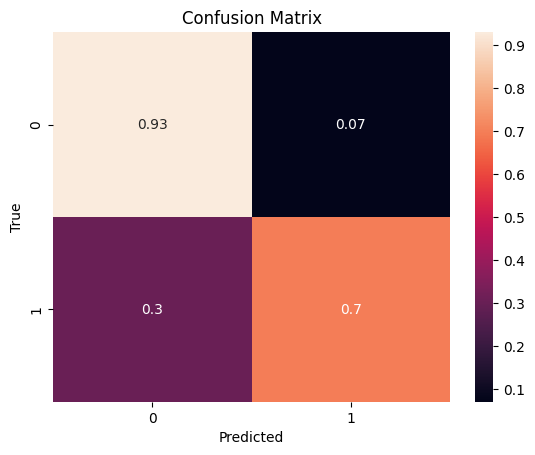

AUC: 0.8130



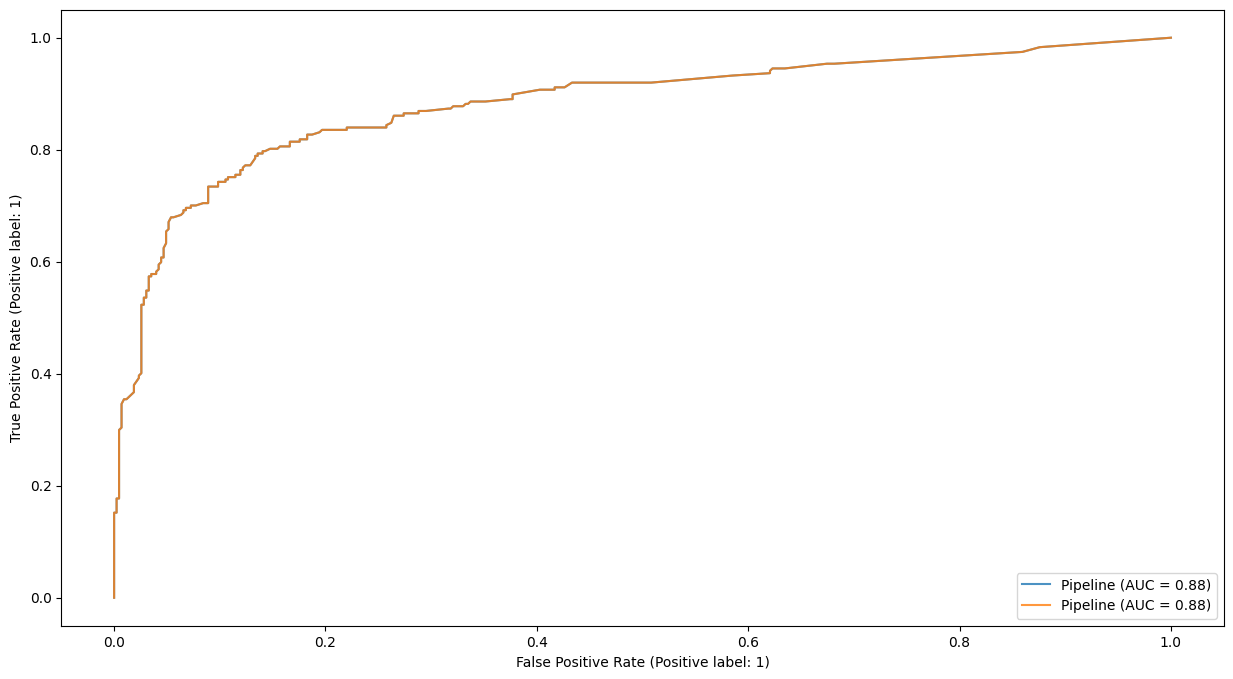

In [16]:
# print classification report
print(classification_report(y_test, final_predictions))

# plot confusion matrix
fig , ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, final_predictions, normalize='true'), annot=True, ax=ax)
ax.set_title("Confusion Matrix")
ax.set_ylabel("True")
ax.set_xlabel("Predicted")
plt.show()

# print and plot roc_auc
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, final_predictions)))

plt.figure(figsize=(15, 8))
ax = plt.gca()
lgbm_disp = RocCurveDisplay.from_estimator(final_model, X_test, y_test, ax=ax, alpha=0.8)
lgbm_disp.plot(ax=ax, alpha=0.8)
plt.show()

## Permutation feature importance

Now we will discuss post-hoc methods for global interpretation. This is algorithms that are model agnostic and will allow us to interpret globally that is on average both white box and black box models. Permutation feature importance is one of the most popular methods to do it. Let's summarize somethings:

* Post-hoc interpretability method -> used AFTER training the machine learning model.
* Global interpretation -> Determines feature importance on average for a given dataset.
* Model agnostic -> Especially useful for opaque estimators.

Permutation feature importance is both a model inspection technique, but it can also be used as a feature selection technique.

* For model inspection, permutation feature importance allows us to explain how the model makes the decisions, which features are important for the output of that particular model.
* For feature selection, permutation feature importance will allow us to select featres with higher importance after we determine the importance of those features.

Obs:

* Permutation feature importance is relative to the model.
* It does not reflect the intrisic predictive value of a feature.

**Mechanism**

we take a training set, and with this training set we train a machine learning model and then to evaluate feature importance, utilizing permutation feature importance, we usually do it using a test set or a held out sample.

We take a test set and utilizing machine learning model, we obtain a set of predictions and using a metric of our choosing, we obtain the performance of this model on the test set. Now we start applying perfumatation feature importance.

* The first step is to shuffle one of the features, then using the same machine learning model, but now this test set with one of the features shuffled, we obtain the predictions and with that prediction, we obtain a measure of performance utilizing the same metric used before. If the feature was important, there's gonna be a gap (drop) or a difference between the model performance utilizing the raw test set and the performance obtained with the suffled feature. This drop in performance constitutes the permutation importance of this particular feature.

* Then we take the test set again and we shuffle the second feature (the other feature is back to the correct order) and repeat the same proccess above.

* Repeat the same proccess for all features.

The drop in performance that was obtained after shuffling each one of the features and the higher this performance drop, intuitively, the more important this feature is.

**Randomness**

Because this is a random shuffle, different runs of the code or different seeds are gonna return different values for feature importance. So the way to account for this randomness is essentially to shuffle each feature multiple times and then take the average and, if possible, the standard deviation. There are 3 python implementations that incorporate permutation feature importance.

* Scikit-learn.
* Eli5.
* Feature-engine.

### Global Interpretation - Tree derived

In [17]:
# Get the best estimator from the grid search
rf = grid_search.best_estimator_.named_steps['rf']

# importance based on each tree
# Let's take the importance derived by each single decisiont tree
global_exp = pd.DataFrame()

for i in range(10):  # Assuming there are 10 trees in your forest, adjust as needed
    # Get the feature importances of the i-th tree and add them to the DataFrame
    global_exp[f'tree_{i+1}'] = rf.estimators_[i].feature_importances_

# Set the feature names as indices of the DataFrame
global_exp.index = grid_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out()

# Calculate the mean importance of features across all trees
global_exp['importance'] = global_exp.mean(axis=1)
global_exp

,tree_1,tree_2,tree_3,tree_4,tree_5,tree_6,tree_7,tree_8,tree_9,tree_10,importance
quantitative_preproc__Application order,0.000000,0.000519,0.006280,0.000000,0.000000,0.000000,0.000000,0.006773,0.000000,0.003757,0.001733
quantitative_preproc__Age at enrollment,0.236975,0.006097,0.074631,0.188929,0.211362,0.079926,0.106671,0.004464,0.041547,0.051236,0.100184
quantitative_preproc__Curricular units 1st sem (evaluations),0.030041,0.021028,0.011696,0.017630,0.116386,0.031226,0.194862,0.022054,0.003757,0.000000,0.044868
quantitative_preproc__Curricular units 1st sem (without evaluations),0.005138,0.000000,0.000000,0.002632,0.005849,0.004054,0.013420,0.000000,0.002604,0.000000,0.003370
quantitative_preproc__Curricular units 2nd sem (enrolled),0.053549,0.059039,0.000000,0.007466,0.081889,0.002941,0.036277,0.072718,0.011464,0.069276,0.039462
quantitative_preproc__Curricular units 2nd sem (approved),0.269405,0.774437,0.767023,0.689770,0.458818,0.704361,0.156277,0.044996,0.115502,0.171456,0.415204
quantitative_preproc__Curricular units 2nd sem (grade),0.404891,0.013942,0.009475,0.000570,0.017002,0.064237,0.463481,0.672631,0.420919,0.608507,0.267565
quantitative_preproc__GDP,0.000000,0.000000,0.000000,0.003412,0.000000,0.000000,0.000000,0.019345,0.016859,0.001945,0.004156
remainder__Tuition fees up to date,0.000000,0.124938,0.130895,0.089591,0.108694,0.109525,0.029013,0.156573,0.387348,0.093823,0.123040
remainder__International,0.000000,0.000000,0.000000,0.000000,0.000000,0.003730,0.000000,0.000447,0.000000,0.000000,0.000418


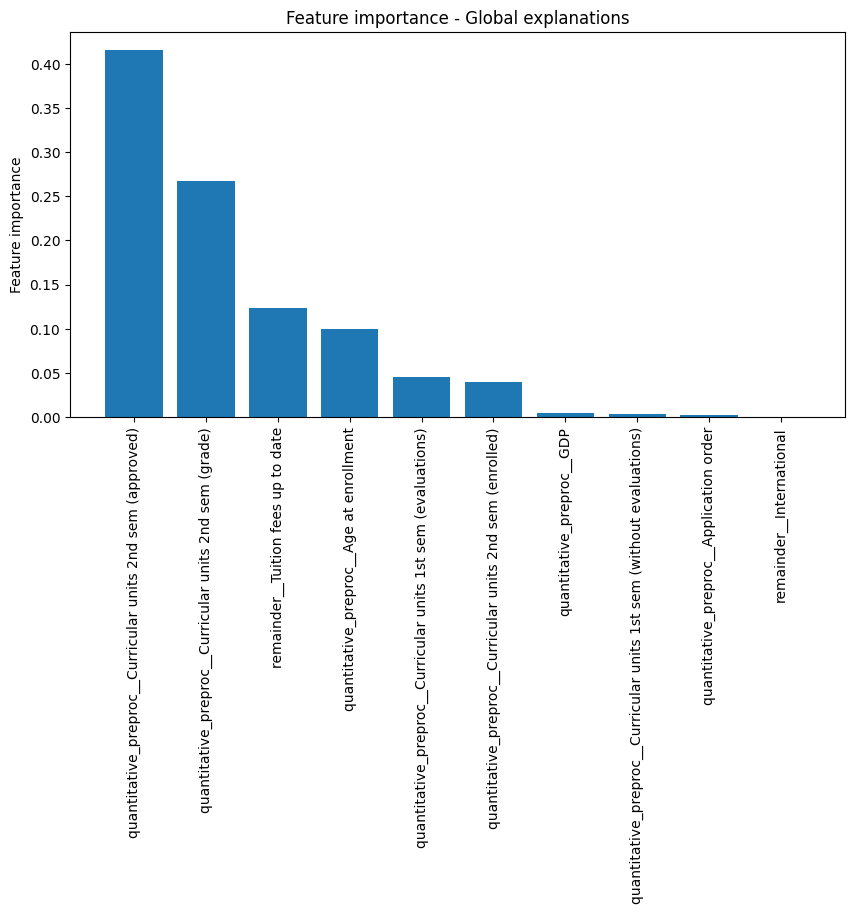

In [18]:
# Sort the DataFrame by the 'importance' column in descending order and plot it
global_exp_sorted = global_exp.sort_values(by='importance', ascending=False)
plt.figure(figsize=(10, 5))  # Adjust the figure size as needed
plt.bar(global_exp_sorted.index, global_exp_sorted['importance'])
plt.ylabel("Feature importance")
plt.title("Feature importance - Global explanations")
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

### Global Interpretation - Permutation feature importance

In [19]:
X_train_processed = preprocessor.fit_transform(X)
X_test_processed = preprocessor.transform(X_test)

In [20]:
r = permutation_importance(
    rf, 
    X_test_processed, # we use the test set
    y_test,
    scoring = "accuracy", # we can use any metric
    n_repeats = 5, 
    random_state = 42
)

In [21]:
# contains is an array of arrays
# contains the individual importance of each repetition#
# and the mean and std
importance = pd.DataFrame(
    {"importance_mean": r["importances_mean"],
     "importance_std": r["importances_std"]},
    index = grid_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out())

importance

,importance_mean,importance_std
quantitative_preproc__Application order,0.000000,0.000000
quantitative_preproc__Age at enrollment,0.015361,0.007153
quantitative_preproc__Curricular units 1st sem (evaluations),0.003916,0.001807
quantitative_preproc__Curricular units 1st sem (without evaluations),0.000000,0.000952
quantitative_preproc__Curricular units 2nd sem (enrolled),0.006024,0.001905
quantitative_preproc__Curricular units 2nd sem (approved),0.107229,0.005505
quantitative_preproc__Curricular units 2nd sem (grade),0.008434,0.002447
quantitative_preproc__GDP,0.001807,0.001756
remainder__Tuition fees up to date,0.045482,0.004800
remainder__International,0.000000,0.000000


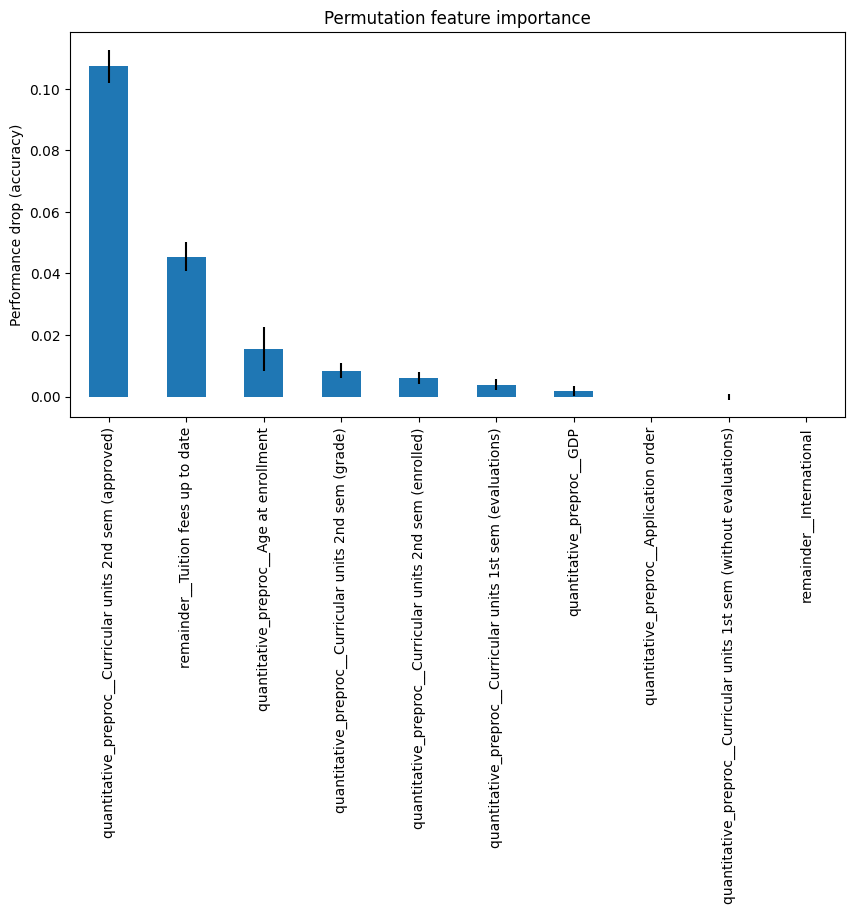

In [22]:
# The larger the drop, the more important the feature
importance["importance_mean"].sort_values(
    ascending=False
).plot(figsize=(10, 5), kind="bar", yerr=importance["importance_std"])

plt.title("Permutation feature importance")
plt.ylabel("Performance drop (accuracy)")
plt.show()

Compared to the feature importance that the random forest gives us, some things are a little divergent, but overall, they seem to corroborate each other.

## Conclusion

Quantifying feature importance by permutation is a relatively straightforward method, so there's not much more to it. Let's see some considerations to keep in mind when we apply this method:

1. Where should we evaluate the importance of the feature when using permutation? It is important to calculate the permutation feature importance utilizing the test set or a held out sample. If model overfits, deriving feature importance from the train set is meaningless. Deriving feature importance from the test set, shows it's generalization importance.

2. The aggregated importance of every feature is greater than the drop in performance when shuffling all features. This method is not additive.

3. Shuffling is relatively costly. Many features or repeating the shuffling multiple times may require some time.

4. When features are correlated, their importance is distributed across them, resulting in reduced individual importance compared to their uncorrelated counterparts. Diminished importance may indicate correlation rather than inherent feature significance.

5. Combining permutation feature importance with recursive feature elimination may help mitigate the effect of correlation. Removing a feature results in an increase in performance of the remaining variables. It comes with an increase of the cost.

**Credits**

https://www.trainindata.com/